# Classification de races de chien¶

## VGG-16 modèle entrainé

Importation du modèle VGG-16


In [3]:
import os
%cd
from keras.applications.vgg16 import VGG16,preprocess_input

model = VGG16( include_top=True,
              weights='imagenet',
              input_tensor=None,
              input_shape=None,
              pooling=None,
              classes=1000,
              classifier_activation='softmax'
             ) # Création du modèle VGG-16 implementé par Keras


/home/fedecabre


/home/fedecabre


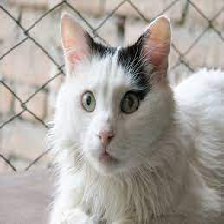

In [4]:
%cd
# à la racine pour avoir accès aux datas
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

project_path ='Documents/OC_Ingenieur_ML/P6_Classez_des_images/'
img = load_img(project_path+'data/cat.jpeg', target_size=(224, 224))  # Charger l'image
display(img)

img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [7]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n02124075', 'Egyptian_cat', 0.25156984), ('n02127052', 'lynx', 0.19743551), ('n01877812', 'wallaby', 0.16383485)]


# Preparation des données

## Création du dataset

In [8]:
import os
import numpy as np
import imageio
from xml.dom import minidom
from PIL import Image

def make_dataset_race(folder,image_size=224, num_channels = 3,preprocess=True):
    '''
    Fonction pour créér le dataset pour un dossier de race de chien
    Les images sont croppées, redimensionnées et enregistrés dans un nouveau dossier 
    output : dataset des images d'une race
    
    '''
    image_files=os.listdir(project_path+folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    num_images = 0
    for image in image_files:
        image_file = project_path+folder+'/'+image
        image_data = imageio.imread(image_file)
        if image_data.shape[2]==num_channels: # on prend que les images avec 3 channels
            annon_file = project_path+'data/Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]

            #bounding carré rempli de noir
            x = xmax-xmin
            y = ymax-ymin
            if x<y:
                squarre_image = np.zeros((y,y,num_channels))
                delta = ((y-x)//2)
                squarre_image[:new_image_data.shape[0],delta:(new_image_data.shape[1])+delta,:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)
            if x>y:
                squarre_image = np.zeros((x,x,num_channels))
                delta = ((x-y)//2)
                squarre_image[delta:(new_image_data.shape[0]+delta),:new_image_data.shape[1],:] = new_image_data
                squarre_image = squarre_image.astype(np.uint8)

            new_image = Image.fromarray(squarre_image)
            new_image = new_image.resize(size=(image_size,image_size))
            crop_dir = project_path+'data/Cropped/'+ folder.split('/')[-1]
            if os.path.exists(project_path+'data/Cropped/') is False:
                os.mkdir(project_path+'data/Cropped/')
            if os.path.exists(crop_dir) is False:
                os.mkdir(crop_dir)
            new_image.save(crop_dir+'/'+image)  # Enregistrer les images cropés
            if preprocess:
                dataset[num_images, :, :, :] = preprocess_input(np.array(new_image,dtype='float32'))
            else:
                dataset[num_images, :, :, :] = np.array(new_image,dtype='float32')
            num_images = num_images + 1
    dataset = dataset[0:num_images, :, :, :]
    print('Full dataset tensor:', dataset.shape)
    return dataset


In [9]:
def make_arrays(nb_rows, img_size):
    '''
    fonction pour la création de datasets et labels vides
    '''
    if nb_rows:
        dataset = np.zeros((nb_rows,img_size, img_size,num_channels), dtype=np.float32)
        labels = np.zeros((nb_rows,), dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [28]:
images_folders_path = "data/Images/"
images_folders=os.listdir(project_path+images_folders_path)

num_classes = 20 #len(images_folders)
train_size  = 2000
valid_size  = 1000
image_size  = 224 # 90 ça fonctionne pour whitenning
num_channels= 3
preprocess = False

# Création des datasets vides
valid_dataset, valid_labels = make_arrays(valid_size, image_size)
train_dataset, train_labels = make_arrays(train_size, image_size)


vsize_per_class = valid_size // num_classes # il peut être NULL
tsize_per_class = train_size // num_classes

start_v, start_t = 0, 0
end_v, end_t = vsize_per_class, tsize_per_class
end_l = vsize_per_class+tsize_per_class

# make a dictionary
dog_race_dict = dict()

for label,folder in enumerate(images_folders):
    if label < num_classes :
        print(str(label+1)+'/'+str(num_classes)+' - '+folder.split('-')[-1])
        dog_race_dict[folder.split('-')[-1]] = label
        dataset_race = make_dataset_race('data/Images/'+folder,image_size=image_size,preprocess=preprocess)
        train_breed = dataset_race[vsize_per_class:end_l, :, :, :]
        train_dataset[start_t:end_t, :, :, :] = train_breed
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
        if valid_dataset is not None:
            valid_breed = dataset_race[:vsize_per_class, :, :, :]
            valid_dataset[start_v:end_v, :, :, :] = valid_breed
            valid_labels[start_v:end_v] = label
            start_v += vsize_per_class
            end_v += vsize_per_class

dog_race_invert_dict = {v: k for k, v in dog_race_dict.items()}

1/20 - Bedlington_terrier
Full dataset tensor: (182, 224, 224, 3)
2/20 - collie
Full dataset tensor: (153, 224, 224, 3)
3/20 - Greater_Swiss_Mountain_dog
Full dataset tensor: (168, 224, 224, 3)
4/20 - bull_mastiff
Full dataset tensor: (156, 224, 224, 3)
5/20 - flat_coated_retriever
Full dataset tensor: (152, 224, 224, 3)
6/20 - Leonberg
Full dataset tensor: (210, 224, 224, 3)
7/20 - affenpinscher
Full dataset tensor: (150, 224, 224, 3)
8/20 - English_foxhound
Full dataset tensor: (157, 224, 224, 3)
9/20 - kuvasz
Full dataset tensor: (150, 224, 224, 3)
10/20 - tan_coonhound
Full dataset tensor: (159, 224, 224, 3)
11/20 - bloodhound
Full dataset tensor: (187, 224, 224, 3)
12/20 - Norfolk_terrier
Full dataset tensor: (172, 224, 224, 3)
13/20 - Great_Pyrenees
Full dataset tensor: (213, 224, 224, 3)
14/20 - haired_pointer
Full dataset tensor: (152, 224, 224, 3)
15/20 - Australian_terrier
Full dataset tensor: (196, 224, 224, 3)
16/20 - Rottweiler
Full dataset tensor: (152, 224, 224, 3)
17/20

In [11]:
dog_race_dict

{'Bedlington_terrier': 0,
 'collie': 1,
 'Greater_Swiss_Mountain_dog': 2,
 'bull_mastiff': 3,
 'flat_coated_retriever': 4,
 'Leonberg': 5,
 'affenpinscher': 6,
 'English_foxhound': 7,
 'kuvasz': 8,
 'tan_coonhound': 9,
 'bloodhound': 10,
 'Norfolk_terrier': 11,
 'Great_Pyrenees': 12,
 'haired_pointer': 13,
 'Australian_terrier': 14,
 'Rottweiler': 15,
 'Tibetan_terrier': 16,
 'Eskimo_dog': 17,
 'Maltese_dog': 18,
 'Boston_bull': 19}

In [12]:
print(train_dataset.shape)
print(train_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)

(2000, 224, 224, 3)
(2000,)
(1000, 224, 224, 3)
(1000,)


In [13]:
from keras.utils.np_utils import to_categorical

train_labels_categorical = to_categorical(train_labels, num_classes=num_classes)
valid_labels_categorical = to_categorical(valid_labels, num_classes=num_classes)
print(train_labels_categorical.shape)
print(valid_labels_categorical.shape)

(2000, 20)
(1000, 20)


In [29]:
#on garde une copie du dataset pour l'utiliser avec les filtres
train_dataset_white = train_dataset.copy()
valid_dataset_white = valid_dataset.copy()
train_dataset_CLAHE = train_dataset.copy()
valid_dataset_CLAHE = valid_dataset.copy()

In [ ]:
# on traite les datasets avec le preproces de VGG16
preprocess_input(train_dataset)
preprocess_input(valid_dataset)
print("fait")

## Whitening entraînement

In [14]:
from skimage.transform import resize

def zca_whitening_dataset(X,subset,factor=4,make_matrix=True,U=None,S=None,V=None):
    """
        Fonction pour entrainer les matrices de whitening, les enregistrer et 
        Traiter le dataset
    """
    print(X.shape)
    X = X[:subset]
    print(X.shape)
    
    # reduction de dimension pour que le calcul puisse se faire avec 16 Gb de RAM
    X_resized = np.zeros((X.shape[0],X.shape[1]//factor,X.shape[2]//factor,X.shape[3]))
    for i in range(len(X)):
        X_resized[i] = resize(X[i], (X.shape[1]//factor,X.shape[2]//factor))
    print(X_resized.shape)
    X_resized = X_resized.reshape(X_resized.shape[0], 
                                  X_resized.shape[1]*X_resized.shape[2]*X_resized.shape[3])
    print(X_resized.shape)
    print( 'X.min()', X_resized.min())
    print( 'X.max()', X_resized.max())
    X_resized_norm = X_resized / 255
    print( 'X.min()', X_resized_norm.min())
    print( 'X.max()', X_resized_norm.max())
    
    X_resized_norm.mean(axis=0).shape #This gives us values which is the number of means — one per pixel.
    X_resized_norm = X_resized_norm - X_resized_norm.mean(axis=0)
    X_ZCA_rescaled_resized = np.zeros(X.shape)
    if make_matrix:
        cov = np.cov(X_resized_norm, rowvar=False) # it will use the columns as variables (or features) and the rows as observations.
        print(cov.shape)

        U,S,V = np.linalg.svd(cov)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
        print(U.shape, S.shape)

        # elargir les matrices pour transformer les images
        U = U.astype('float32')
        S = S.astype('float32')
        V = V.astype('float32')
        
        print (U.shape)

        U = U.reshape(X.shape[1]//factor,
                      X.shape[2]//factor,
                      X.shape[3],
                      X.shape[1]//factor,
                      X.shape[2]//factor,
                      X.shape[3]
                     )
        
        S = S.reshape(X.shape[1]//factor,
                      X.shape[2]//factor,
                      X.shape[3]
                     )                     
        
        # elargir les matrices pour transformer les images
        U = np.repeat(np.repeat(np.repeat(np.repeat(U, 2, axis=4), 2, axis=3), 2, axis=1), 2, axis=0)
        S = np.repeat(np.repeat(S, 2, axis=1), 2, axis=0)
        
        U = U.reshape(X.shape[1]//factor*2*X.shape[2]//factor*2*X.shape[3],
                      X.shape[1]//factor*2*X.shape[2]//factor*2*X.shape[3]
                     )
        
        S = S.reshape(X.shape[1]//factor*2*X.shape[2]//factor*2*X.shape[3]
                     ) 
        # Imposible MemoryError: Unable to allocate 169. GiB for an array with shape (150528, 150528) and data type float64
        np.save(project_path+'models/U_matrix.npy', U)
        np.save(project_path+'models/S_matrix.npy', S)
    
    else :
        
        # Whitening constant: prevents division by zero
        epsilon = 1e-5

        # ZCA Whitening matrix: U * Lambda * U'
        X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_resized_norm.T).T 
        X_ZCA_rescaled = ((X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min()))*255
        print(X_ZCA_rescaled.shape)
        X_ZCA_rescaled = X_ZCA_rescaled.reshape(X.shape[0],
                                                X.shape[1]//2,
                                                X.shape[2]//2,
                                                X.shape[3])
        print(X_ZCA_rescaled.shape)
        
        for i in range(len(X)):
            X_ZCA_rescaled_resized[i] = resize(X_ZCA_rescaled[i], (X.shape[1],X.shape[2]))
        print('min:', X_ZCA_rescaled_resized.min())
        print('max:', X_ZCA_rescaled_resized.max())
    return X_ZCA_rescaled_resized,U,S

In [15]:
# Géneration de la matrice --> 10 minutes de calcul
# matrice enregistré dans le disque pour gagner du temps
#_ ,U,S = zca_whitening_dataset(train_dataset_white.astype('float32'),1000,factor=4)

# Fonctions métriques et d'affichage

## Fonction métriques

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    '''
        Fonction pour calculter le recall utilisé pendant l'entraînenemt des modèles
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    '''
        Fonction pour calculter la précision utilisé pendant l'entraînenemt des modèles
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    '''
        Fonction pour calculter le f1 score utilisé pendant l'entraînenemt des modèles
    '''
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
def min_loss_max_acc(model_info):
    '''
    trouve dans l'historique d'entraînement l'epoch avec le loss_min et acc_max et leur valeur
    '''
    loss_min = min(model_info.history['val_loss'])
    loss_min_epoch = model_info.history['val_loss'].index(loss_min)+1
    acc_max = max(model_info.history['val_accuracy'])
    acc_max_epoch = model_info.history['val_accuracy'].index(acc_max)+1
    return np.round(loss_min,decimals=5), loss_min_epoch, np.round(acc_max,decimals=5), acc_max_epoch

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
def clas_report(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    '''
    calcule et affiche le Classification Report
    '''
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    print('Classification Report')
    print(classification_report(valid_labels, valid_labels_pred, target_names=dog_race_dict.keys()))

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def conf_matr(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    '''
    calcule et affiche la matrice de confusion
    '''
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                      columns = [i for i in dog_race_dict.keys()])
    plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    sn.heatmap(df_cm, annot=True)

In [20]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve,auc,roc_auc_score

def multiclass_roc_auc_score(model,valid_dataset, valid_labels, labels,dog_race_dict=dog_race_dict, average="macro"):
    '''
    calcule et affiche le multiclass ROC
    '''
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8),)
    fig.patch.set_facecolor('w')
    lb = LabelBinarizer()
    lb.fit(valid_labels)
    y_test = lb.transform(valid_labels)
    y_pred = lb.transform(valid_labels_pred)

    for (idx, c_label) in enumerate(labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    return roc_auc_score(y_test, y_pred, average=average)

## Fonctions d'affichage

In [21]:
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(project_path, "Graphs")
os.makedirs(IMAGES_PATH, exist_ok=True)

IMAGES_PATH = project_path + "Graphs/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [22]:
import matplotlib.pyplot as plt

def plot_loss(model_info,graph_name,loss_min,tight_layout=True, fig_extension="png", resolution=300):
    '''
    affiche et enregistre le plot loss à partir de l'historique du modèle
    '''
    loss = model_info.history['loss']
    val_loss = model_info.history['val_loss']

    epochs = range(1, len(loss) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.axvline(x=loss_min,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

In [23]:
plt.clf()   # clear figure

def plot_accuracy(model_info,graph_name,acc_max,tight_layout=True, fig_extension="png", resolution=300):
    '''
    affiche et enregistre le plot accuracy à partir de l'historique du modèle
    '''
    acc_train = model_info.history['accuracy']
    acc_val = model_info.history['val_accuracy']
    
    epochs = range(1, len(acc_train) + 1)
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('w')
    plt.plot(epochs, acc_train, 'bo', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy '+ graph_name+'\n'
              "num_classes = " + str(num_classes) +
              ", train_size = " + str(train_size) + 
              ", valid_size = " + str(valid_size) + '\n'
              "image_size = " + str(image_size) +
              ", num_channels = " + str(num_channels))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.axvline(x=acc_max,color='red',linestyle='--')
    fig_id=(graph_name + ' training_and_validation_accuracy'+ 
              "-num_classes=" + str(num_classes) +
              "-train_size=" + str(train_size) + 
              "-valid_size=" + str(valid_size) + 
              "-image_size=" + str(image_size) +
              "-num_channels=" + str(num_channels))
    save_fig(fig_id, tight_layout, fig_extension, resolution)
    plt.show()
    

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
def plotImage(X):
    plt.figure(figsize=(6, 6))
    plt.imshow(X.reshape(image_size,image_size,3))
    plt.axis('off')
    plt.show()
    plt.close()

# Modèle CNN classique

### modèle

In [25]:
from functools import partial
from keras import layers
from keras.models import Sequential
from keras import Model

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=num_classes, activation='softmax'),
])

In [26]:
# Compiler le modèle
model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       5

### Entraînement

In [27]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model0_info = model.fit(train_dataset/255,train_labels_categorical,
                           epochs=70,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset/255,valid_labels_categorical)
                           )

Epoch 1/70
16/16 [==============================] - 25s 1s/step - loss: 1.7722 - accuracy: 0.1980 - f1_m: 0.0121 - precision_m: 0.0714 - recall_m: 0.0098 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/70
16/16 [==============================] - 6s 395ms/step - loss: 1.6102 - accuracy: 0.1800 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/70
16/16 [==============================] - 6s 392ms/step - loss: 1.6098 - accuracy: 0.1920 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/70
16/16 [==============================] - 6s 394ms/step - loss: 1.6098 - accuracy: 0.1760 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00

16/16 [==============================] - 7s 444ms/step - loss: 1.6108 - accuracy: 0.2040 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6094 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 58/70
16/16 [==============================] - 7s 444ms/step - loss: 1.6090 - accuracy: 0.2220 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6094 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 59/70
16/16 [==============================] - 7s 443ms/step - loss: 1.6101 - accuracy: 0.1720 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6095 - val_accuracy: 0.2000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 60/70
16/16 [==============================] - 7s 442ms/step - loss: 1.6092 - accuracy: 0.2000 - f1_m: 0.0000e+00 - precision_m: 0.00

### Résultats

Saving figure model0 val_loss min=0.33618 training_and_validation_accuracy-num_classes=2-train_size=200-valid_size=100-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

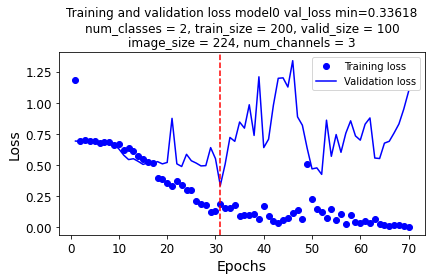

Saving figure model0 val_acc_max=0.9 training_and_validation_accuracy-num_classes=2-train_size=200-valid_size=100-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

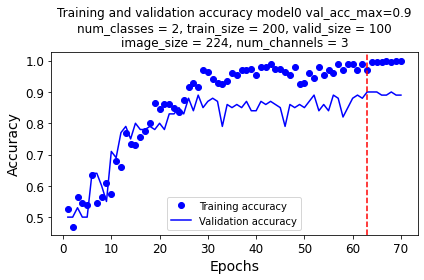

In [60]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model0_info)
plot_loss(model0_info,'model0 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model0_info,'model0 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


Saving figure model0 val_loss min=1.60944 training_and_validation_accuracy-num_classes=5-train_size=500-valid_size=250-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

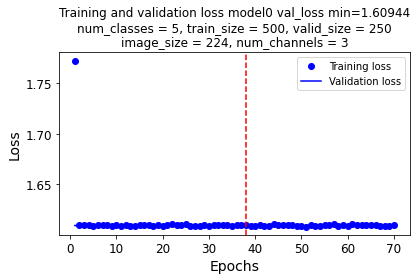

Saving figure model0 val_acc_max=0.2 training_and_validation_accuracy-num_classes=5-train_size=500-valid_size=250-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

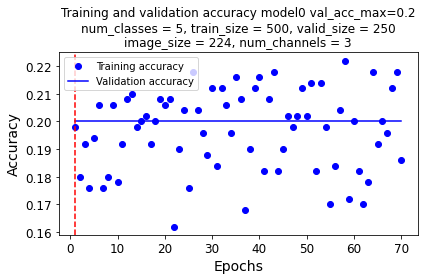

In [28]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model0_info)
plot_loss(model0_info,'model0 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model0_info,'model0 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


# Transfert Learning


## Stratégie fine tunning partiel

### modèle

In [87]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
F = Flatten()(x)
DL1 = Dense(30)(F)
DL2 = Dense(30)(DL1)
predictions = Dense(num_classes, activation='softmax')(DL2)

# Stratégie #2 : extraction de features
for layer in model.layers:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [88]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])

new_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Entraînement

In [36]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model1_info = new_model.fit(train_dataset,train_labels_categorical,
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=(valid_dataset,valid_labels_categorical)
                           )

Epoch 1/15
63/63 [==============================] - 21s 334ms/step - loss: 22.4512 - accuracy: 0.5570 - f1_m: 0.5577 - precision_m: 0.5584 - recall_m: 0.5570 - val_loss: 13.1438 - val_accuracy: 0.7410 - val_f1_m: 0.7436 - val_precision_m: 0.7440 - val_recall_m: 0.7432
Epoch 2/15
63/63 [==============================] - 21s 331ms/step - loss: 2.9107 - accuracy: 0.9215 - f1_m: 0.9221 - precision_m: 0.9221 - recall_m: 0.9221 - val_loss: 9.0737 - val_accuracy: 0.8060 - val_f1_m: 0.8076 - val_precision_m: 0.8076 - val_recall_m: 0.8076
Epoch 3/15
63/63 [==============================] - 21s 335ms/step - loss: 1.1188 - accuracy: 0.9580 - f1_m: 0.9583 - precision_m: 0.9583 - recall_m: 0.9583 - val_loss: 9.5769 - val_accuracy: 0.8050 - val_f1_m: 0.8096 - val_precision_m: 0.8096 - val_recall_m: 0.8096
Epoch 4/15
63/63 [==============================] - 21s 341ms/step - loss: 0.8322 - accuracy: 0.9720 - f1_m: 0.9722 - precision_m: 0.9722 - recall_m: 0.9722 - val_loss: 10.3421 - val_accuracy: 0.79

### Résultats

Saving figure model1 val_loss min=8.49474 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

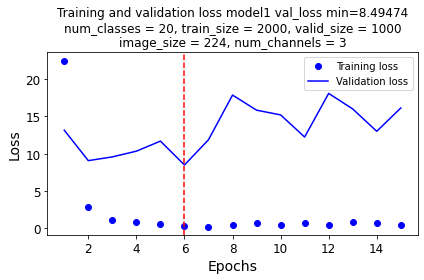

In [47]:
loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model1_info)
plot_loss(model1_info,'model1 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


Saving figure model1 val_acc_max=0.83 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

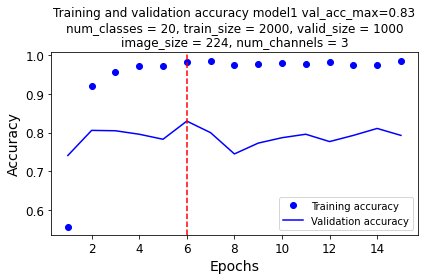

In [48]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model1_info)
plot_accuracy(model1_info,'model1 val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [49]:
clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.92      0.96      0.94        50
                    collie       0.97      0.72      0.83        50
Greater_Swiss_Mountain_dog       0.85      0.92      0.88        50
              bull_mastiff       0.87      0.82      0.85        50
     flat_coated_retriever       0.85      0.88      0.86        50
                  Leonberg       0.98      0.80      0.88        50
             affenpinscher       0.95      0.84      0.89        50
          English_foxhound       0.90      0.70      0.79        50
                    kuvasz       0.58      0.66      0.62        50
             tan_coonhound       0.56      0.82      0.67        50
                bloodhound       0.73      0.70      0.71        50
           Norfolk_terrier       0.91      0.62      0.74        50
            Great_Pyrenees       0.58      0.58      0.58        50
            haired_pointe

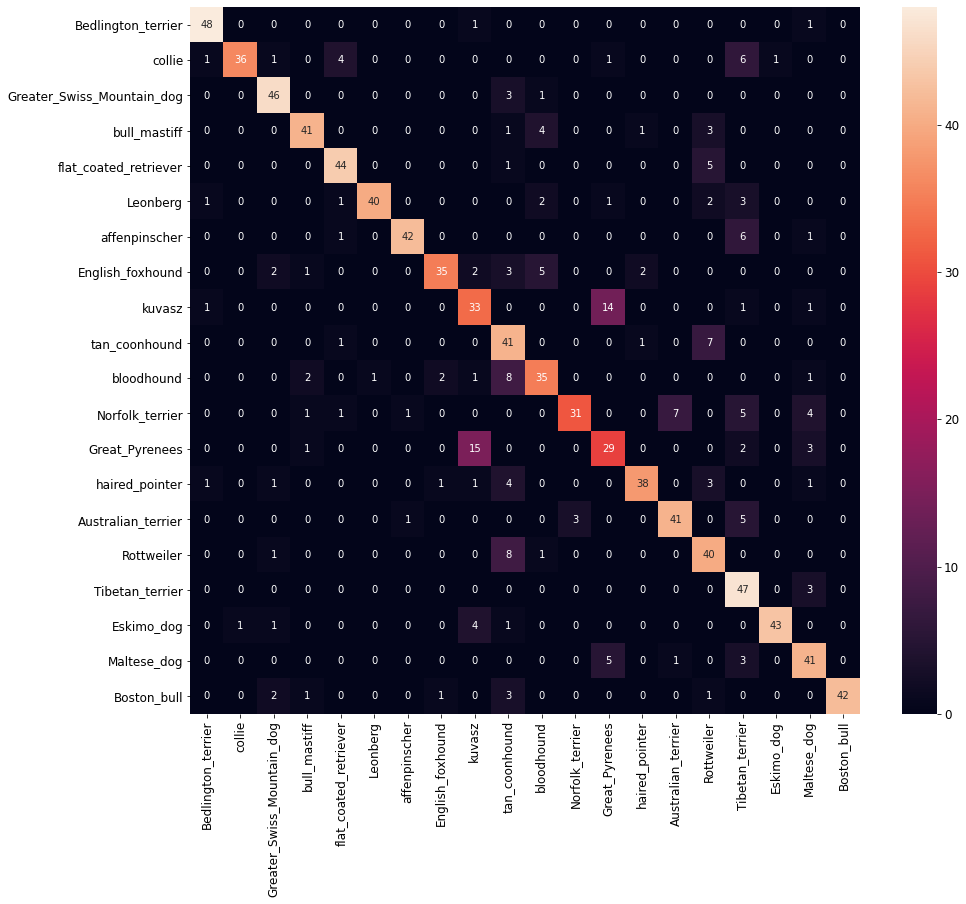

In [50]:
conf_matr(new_model,valid_dataset,valid_labels)

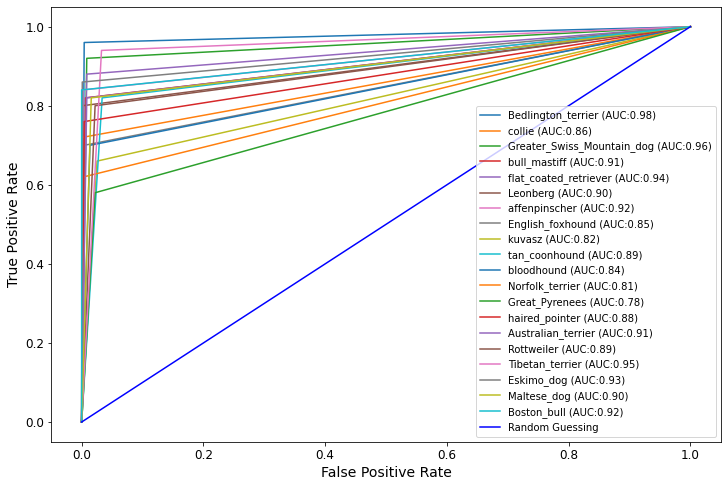

ROC AUC score: 0.8910526315789472


In [51]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

## Stratégie extraction des features (model 2)

### Modèle

In [31]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(image_size, image_size, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [32]:
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy",f1_m,precision_m,recall_m])
new_model.save_weights('model.h5')
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Entraînement

In [33]:
%time
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=15,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset),valid_labels_categorical)
                           )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Epoch 1/15
63/63 [==============================] - 22s 347ms/step - loss: 0.6485 - accuracy: 0.8000 - f1_m: 0.7905 - precision_m: 0.8241 - recall_m: 0.7669 - val_loss: 0.3091 - val_accuracy: 0.8950 - val_f1_m: 0.8963 - val_precision_m: 0.9074 - val_recall_m: 0.8857
Epoch 2/15
63/63 [==============================] - 22s 344ms/step - loss: 0.1299 - accuracy: 0.9555 - f1_m: 0.9561 - precision_m: 0.9604 - recall_m: 0.9519 - val_loss: 0.3033 - val_accuracy: 0.8950 - val_f1_m: 0.8963 - val_precision_m: 0.9064 - val_recall_m: 0.8867
Epoch 3/15
63/63 [==============================] - 24s 380ms/step - loss: 0.0500 - accuracy: 0.9850 - f1_m: 0.9848 - precision_m: 0.9871 - recall_m: 0.9826 - val_loss: 0.2891 - val_accuracy: 0.9120 - val_f1_m: 0.9148 - val_precision_m: 0.9217 - val_recall_m: 0.9082
Epoch 4/15
63/63 [==============================] - 25s 406ms/step - loss: 0.0248 - accuracy: 0.9945 - f1_m: 0.9945 - precision_m: 0.99

### Résultats

Saving figure model2 val_loss min=0.25818 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

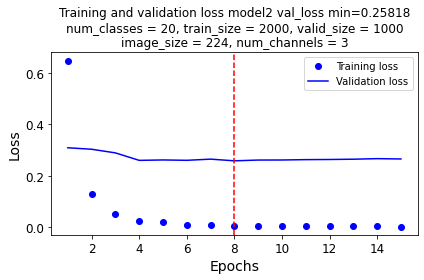

Saving figure model2 val_acc_max=0.919 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

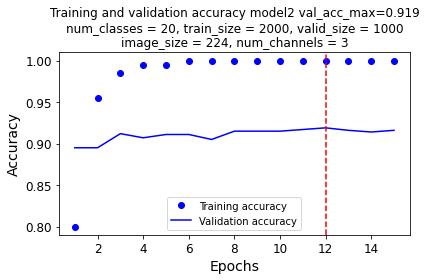

In [34]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max) ,acc_max=acc_max_epoch)

In [35]:

clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.98      1.00      0.99        50
                    collie       0.92      0.96      0.94        50
Greater_Swiss_Mountain_dog       0.94      0.94      0.94        50
              bull_mastiff       0.90      0.90      0.90        50
     flat_coated_retriever       0.96      0.92      0.94        50
                  Leonberg       0.91      0.98      0.94        50
             affenpinscher       1.00      0.90      0.95        50
          English_foxhound       0.87      0.90      0.88        50
                    kuvasz       0.85      0.88      0.86        50
             tan_coonhound       0.83      0.86      0.84        50
                bloodhound       0.89      0.78      0.83        50
           Norfolk_terrier       0.85      0.90      0.87        50
            Great_Pyrenees       0.94      0.90      0.92        50
            haired_pointe

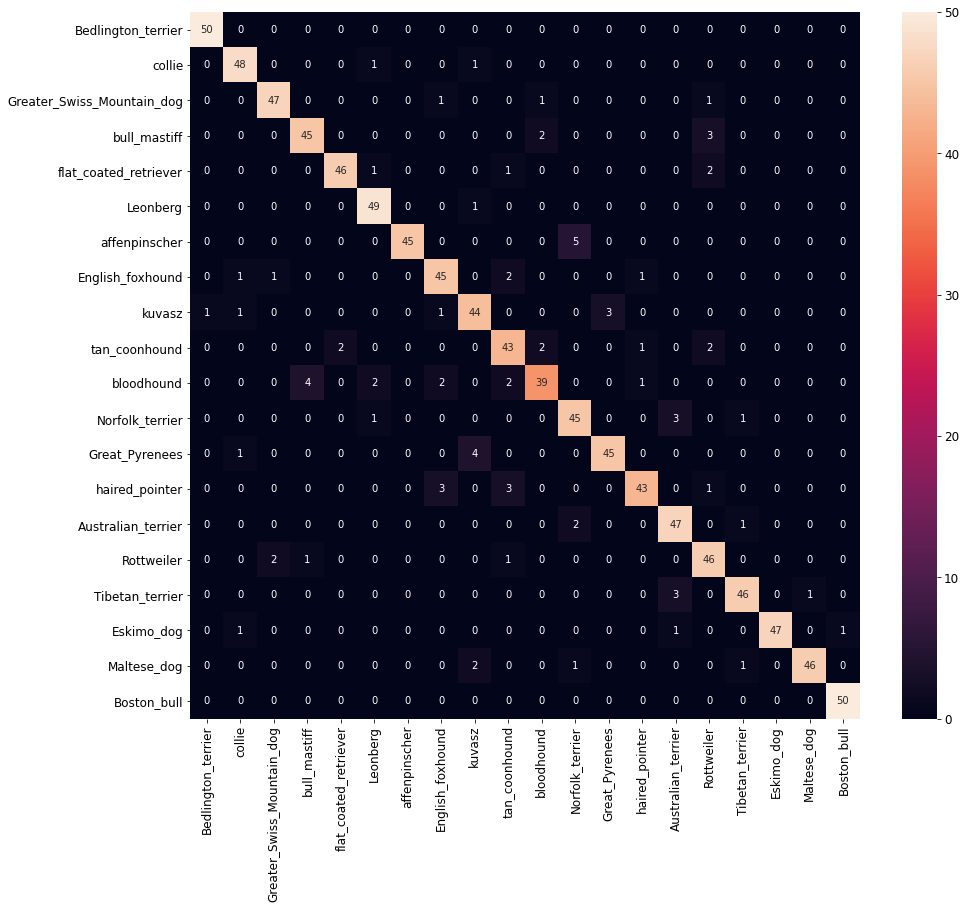

In [36]:
conf_matr(new_model,valid_dataset,valid_labels)

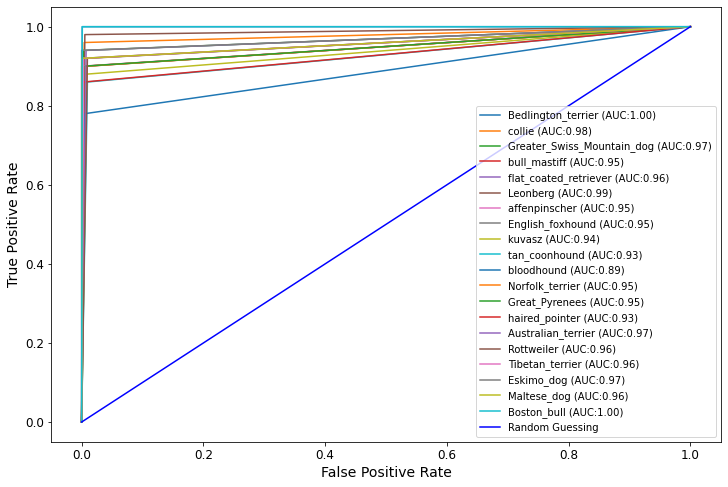

ROC AUC score: 0.9557894736842103


In [37]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

## Whitening (model2)

### reduction dimention du dataset

In [32]:
train_dataset_reduced = np.zeros((train_dataset_white.shape))
train_dataset_temp = np.zeros((train_dataset_white.shape[0],
                              train_dataset_white.shape[1]//2,
                              train_dataset_white.shape[2]//2,
                              train_dataset_white.shape[3]))
for i in range(len(train_dataset)):
        train_dataset_temp[i] = resize(train_dataset_white[i], 
                                       (train_dataset_white.shape[1]//2,
                                        train_dataset_white.shape[2]//2))
        train_dataset_reduced[i] = resize(train_dataset_temp[i], 
                                          (train_dataset_white.shape[1],
                                           train_dataset_white.shape[2]))

In [33]:
valid_dataset_reduced = np.zeros((valid_dataset_white.shape))
valid_dataset_temp = np.zeros((valid_dataset_white.shape[0],
                              valid_dataset_white.shape[1]//2,
                              valid_dataset_white.shape[2]//2,
                              valid_dataset_white.shape[3]))
for i in range(len(valid_dataset)):
        valid_dataset_temp[i] = resize(valid_dataset_white[i], 
                                       (valid_dataset_white.shape[1]//2,
                                        valid_dataset_white.shape[2]//2))
        valid_dataset_reduced[i] = resize(valid_dataset_temp[i], 
                                          (valid_dataset_white.shape[1],
                                           valid_dataset_white.shape[2]))

In [15]:
U = np.load(project_path+'models/U_matrix.npy')
S = np.load(project_path+'models/S_matrix.npy')

### création du dataset avec whitening

In [16]:
ZCA_train_dataset,_,_ = zca_whitening_dataset(train_dataset_white,1000,factor=2,make_matrix=False,U=U,S=S)

(1000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 112, 112, 3)
(1000, 37632)
X.min() 0.0
X.max() 255.0
X.min() 0.0
X.max() 1.0
(1000, 37632)
(1000, 112, 112, 3)
min: 1.2168783415437622e-05
max: 255.0


In [18]:
ZCA_valid_dataset,_,_ = zca_whitening_dataset(valid_dataset_white,500,factor=2,make_matrix=False,U=U,S=S)

(500, 224, 224, 3)
(500, 224, 224, 3)
(500, 112, 112, 3)
(500, 37632)
X.min() 0.0
X.max() 255.0
X.min() 0.0
X.max() 1.0
(500, 37632)
(500, 112, 112, 3)
min: 2.554171151743779e-07
max: 254.99999937320547


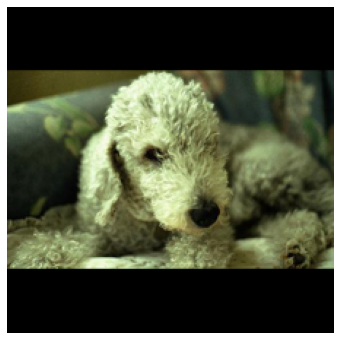

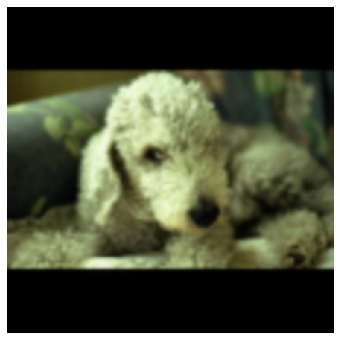

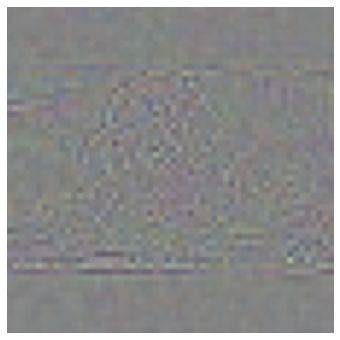

In [35]:
plotImage(train_dataset_white[1, :]/255)
plotImage(train_dataset_reduced[1, :]/255)
plotImage(ZCA_train_dataset[1, :]/255)


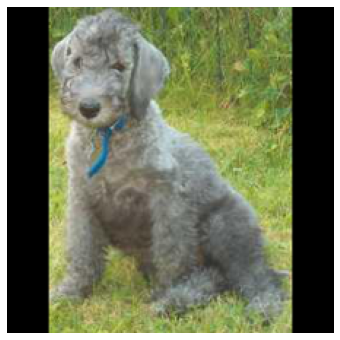

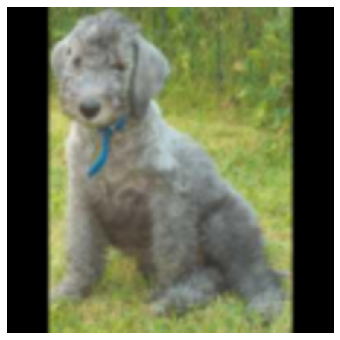

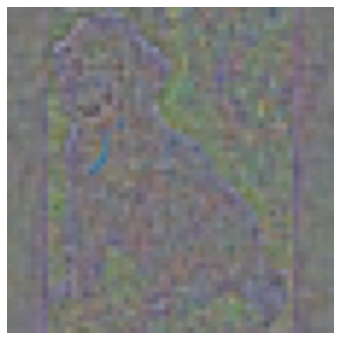

In [37]:
plotImage(valid_dataset_white[1, :]/255)
plotImage(valid_dataset_reduced[1, :]/255)
plotImage(ZCA_valid_dataset[1, :]/255)

In [38]:
preprocess_input(train_dataset_reduced)
preprocess_input(valid_dataset_reduced)
print("fait")

array([[[[-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         ...,
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ]],

        [[-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         ...,
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ]],

        [[-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
         ...,
         [-103.939     , -116.779     , -123.68      ],
         [-103.939     , -116.779     , -123.68      ],
  

In [39]:
preprocess_input(ZCA_train_dataset)
preprocess_input(ZCA_valid_dataset)
print("fait")

array([[[[ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         ...,
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882]],

        [[ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         ...,
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882]],

        [[ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         [ 19.00259208,   5.62768348,  -1.96524704],
         ...,
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882],
         [ 18.74225685,   3.54381034,  -3.97869882]],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


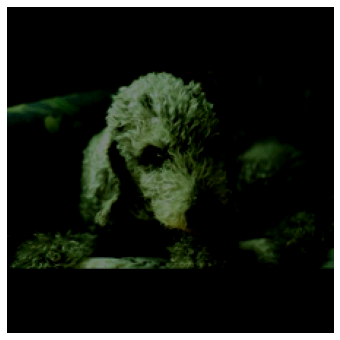

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


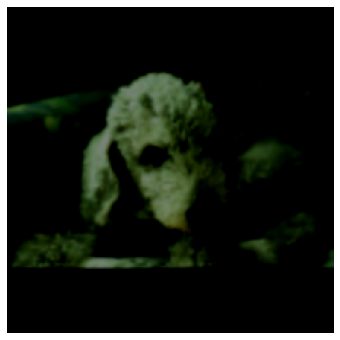

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


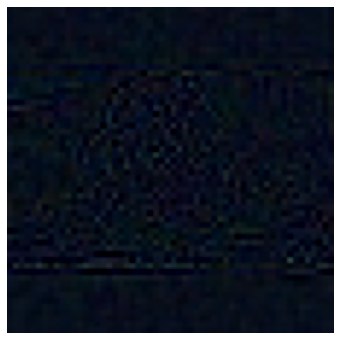

In [40]:
plotImage(train_dataset[1, :]/255)
plotImage(train_dataset_reduced[1, :]/255)
plotImage(ZCA_train_dataset[1, :]/255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


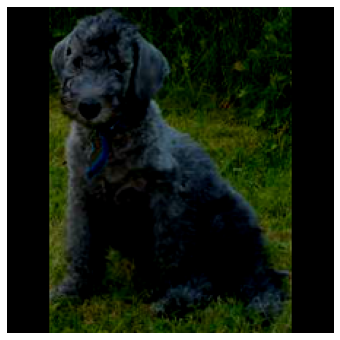

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


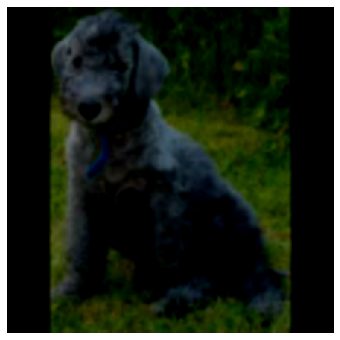

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


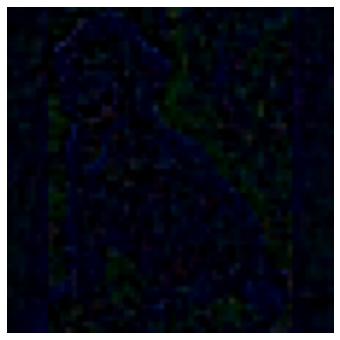

In [41]:
plotImage(valid_dataset[1, :]/255)
plotImage(valid_dataset_reduced[1, :]/255)
plotImage(ZCA_valid_dataset[1, :]/255)

### Entraînement avant whitening

In [42]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_reduced),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_reduced),valid_labels_categorical)
                           )

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.8 µs
Epoch 1/10
32/32 [==============================] - 116s 4s/step - loss: 0.6957 - accuracy: 0.7930 - f1_m: 0.7832 - precision_m: 0.8296 - recall_m: 0.7520 - val_loss: 0.1929 - val_accuracy: 0.9360 - val_f1_m: 0.9352 - val_precision_m: 0.9455 - val_recall_m: 0.9254
Epoch 2/10
32/32 [==============================] - 137s 4s/step - loss: 0.0909 - accuracy: 0.9740 - f1_m: 0.9759 - precision_m: 0.9812 - recall_m: 0.9707 - val_loss: 0.2151 - val_accuracy: 0.9220 - val_f1_m: 0.9177 - val_precision_m: 0.9229 - val_recall_m: 0.9129
Epoch 3/10
32/32 [==============================] - 134s 4s/step - loss: 0.0464 - accuracy: 0.9870 - f1_m: 0.9873 - precision_m: 0.9893 - recall_m: 0.9854 - val_loss: 0.1887 - val_accuracy: 0.9380 - val_f1_m: 0.9423 - val_precision_m: 0.9498 - val_recall_m: 0.9352
Epoch 4/10
32/32 [==============================] - 132s 4s/step - loss: 0.0200 - accuracy: 0.9990 - f1_m: 0.9990 - precision_m: 0.9990 - rec

### Résultat avant whitenning

Saving figure model2 val_loss min=0.1826
images downsizés avant Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

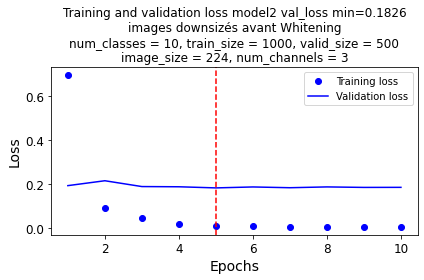

Saving figure model2 val_acc_max=0.938
images downsizés avant Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

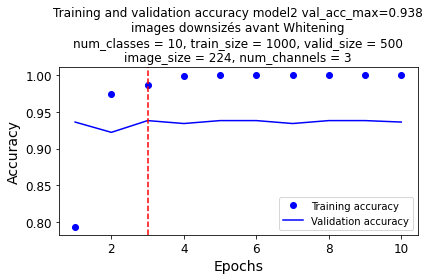

In [43]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images downsizés avant Whitening',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images downsizés avant Whitening',acc_max=acc_max_epoch)

### Entraînement après whitennning

In [44]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((ZCA_train_dataset),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((ZCA_valid_dataset),valid_labels_categorical)
                           )

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Epoch 1/10
32/32 [==============================] - 118s 4s/step - loss: 2.9959 - accuracy: 0.1380 - f1_m: 0.0707 - precision_m: 0.1908 - recall_m: 0.0479 - val_loss: 2.9925 - val_accuracy: 0.1680 - val_f1_m: 0.0524 - val_precision_m: 0.2024 - val_recall_m: 0.0309
Epoch 2/10
32/32 [==============================] - 135s 4s/step - loss: 2.3999 - accuracy: 0.2760 - f1_m: 0.1987 - precision_m: 0.4153 - recall_m: 0.1367 - val_loss: 2.9336 - val_accuracy: 0.1500 - val_f1_m: 0.0986 - val_precision_m: 0.1844 - val_recall_m: 0.0680
Epoch 3/10
32/32 [==============================] - 131s 4s/step - loss: 1.9292 - accuracy: 0.3590 - f1_m: 0.2374 - precision_m: 0.5751 - recall_m: 0.1533 - val_loss: 2.6706 - val_accuracy: 0.1780 - val_f1_m: 0.1058 - val_precision_m: 0.1816 - val_recall_m: 0.0766
Epoch 4/10
32/32 [==============================] - 131s 4s/step - loss: 1.8183 - accuracy: 0.3980 - f1_m: 0.2985 - precision_m: 0.5930 - rec

### Résultat après whitening

Saving figure model2 val_loss min=2.6706
images downsizés avec Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

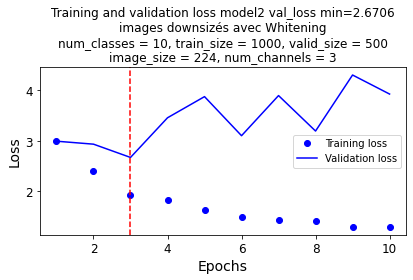

Saving figure model2 val_acc_max=0.182
images downsizés avec Whitening training_and_validation_accuracy-num_classes=10-train_size=1000-valid_size=500-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

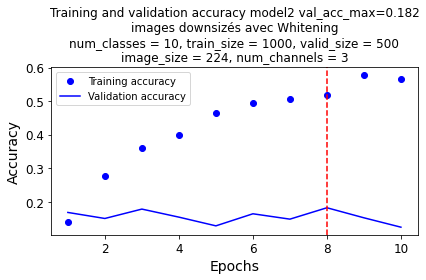

In [45]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images downsizés avec Whitening',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images downsizés avec Whitening',acc_max=acc_max_epoch)

## CLAHE et Equalisation

### Preparation du dataset

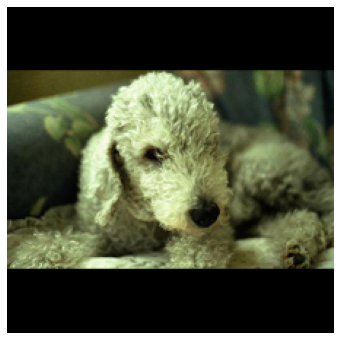

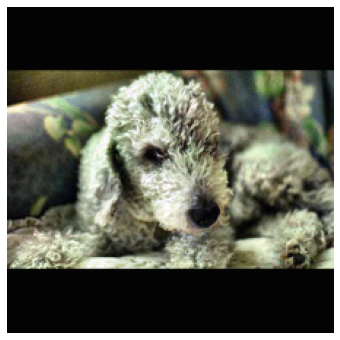

In [38]:
import cv2 as cv

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = (train_dataset_CLAHE[1,:,:,:].astype(np.uint8))

r,g,b = cv.split(img)

img[:,:,0] = clahe.apply(r)
img[:,:,1] = clahe.apply(g)
img[:,:,2] = clahe.apply(b)


plotImage((train_dataset_white[1,:,:,:].astype(np.uint8)))
plotImage(img)

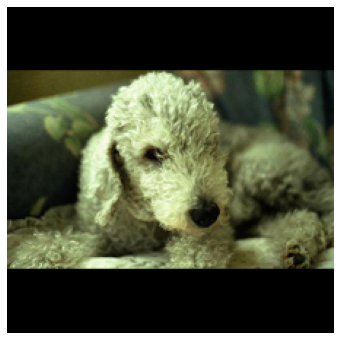

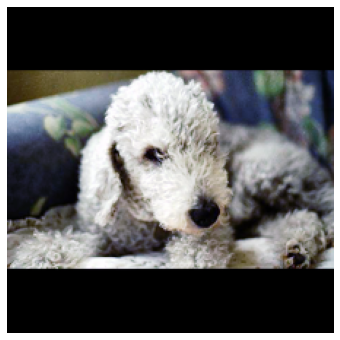

In [39]:
import cv2 as cv

img = (train_dataset_CLAHE[1,:,:,:].astype(np.uint8))

r,g,b = cv.split(img)

img[:,:,0] = cv.equalizeHist(r)
img[:,:,1] = cv.equalizeHist(g)
img[:,:,2] = cv.equalizeHist(b)

img.shape
plotImage((train_dataset_white[1,:,:,:].astype(np.uint8)))
plotImage(img)

In [40]:
import cv2 as cv

# create a CLAHE object (Arguments are optional).
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

train_dataset_EQUA =train_dataset_CLAHE.copy()
valid_dataset_EQUA = valid_dataset_CLAHE.copy()

for i in range(train_dataset_CLAHE.shape[0]):

    img = (train_dataset_CLAHE[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    train_dataset_CLAHE[i,:,:,0] = clahe.apply(r)
    train_dataset_CLAHE[i,:,:,1] = clahe.apply(g)
    train_dataset_CLAHE[i,:,:,2] = clahe.apply(b)
    
for i in range(valid_dataset_CLAHE.shape[0]):

    img = (valid_dataset_CLAHE[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    valid_dataset_CLAHE[i,:,:,0] = clahe.apply(r)
    valid_dataset_CLAHE[i,:,:,1] = clahe.apply(g)
    valid_dataset_CLAHE[i,:,:,2] = clahe.apply(b)

preprocess_input(train_dataset_CLAHE)
preprocess_input(valid_dataset_CLAHE)

array([[[[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        ...,

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -1

In [41]:
import cv2 as cv



for i in range(train_dataset_EQUA.shape[0]):

    img = (train_dataset_EQUA[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    train_dataset_EQUA[i,:,:,0] = clahe.apply(r)
    train_dataset_EQUA[i,:,:,1] = clahe.apply(g)
    train_dataset_EQUA[i,:,:,2] = clahe.apply(b)
    
for i in range(valid_dataset_EQUA.shape[0]):

    img = (valid_dataset_EQUA[i,:,:,:].astype(np.uint8))

    r,g,b = cv.split(img)

    valid_dataset_EQUA[i,:,:,0] = clahe.apply(r)
    valid_dataset_EQUA[i,:,:,1] = clahe.apply(g)
    valid_dataset_EQUA[i,:,:,2] = clahe.apply(b)

preprocess_input(train_dataset_EQUA)
preprocess_input(valid_dataset_EQUA)

array([[[[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ]],

        ...,

        [[-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         [-100.939, -113.779, -120.68 ],
         ...,
         [-100.939, -113.779, -120.68 ],
         [-100.939, -1

### Entraînement et résultats du modèle CLAHE

In [42]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_CLAHE),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_CLAHE),valid_labels_categorical)
                           )

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs
Epoch 1/10
63/63 [==============================] - 22s 344ms/step - loss: 1.0336 - accuracy: 0.7860 - f1_m: 0.7856 - precision_m: 0.8009 - recall_m: 0.7748 - val_loss: 0.8794 - val_accuracy: 0.8520 - val_f1_m: 0.8560 - val_precision_m: 0.8586 - val_recall_m: 0.8535
Epoch 2/10
63/63 [==============================] - 22s 344ms/step - loss: 0.2179 - accuracy: 0.9455 - f1_m: 0.9464 - precision_m: 0.9473 - recall_m: 0.9454 - val_loss: 0.6860 - val_accuracy: 0.8750 - val_f1_m: 0.8774 - val_precision_m: 0.8799 - val_recall_m: 0.8750
Epoch 3/10
63/63 [==============================] - 25s 404ms/step - loss: 0.0644 - accuracy: 0.9785 - f1_m: 0.9779 - precision_m: 0.9782 - recall_m: 0.9777 - val_loss: 0.5634 - val_accuracy: 0.8940 - val_f1_m: 0.8972 - val_precision_m: 0.8990 - val_recall_m: 0.8955
Epoch 4/10
63/63 [==============================] - 25s 402ms/step - loss: 0.0224 - accuracy: 0.9940 - f1_m: 0.9940 - precision_m: 0.994

Saving figure model2 val_loss min=0.51008
images avec CLAHE training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

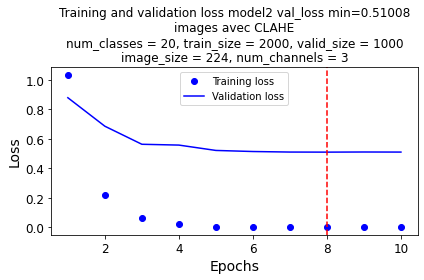

Saving figure model2 val_acc_max=0.906
images images avec CLAHE training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

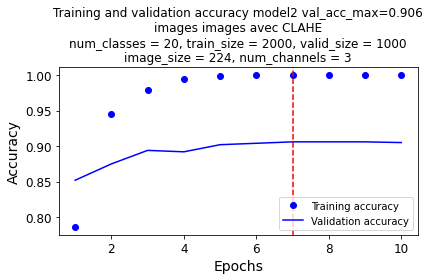

In [43]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images avec CLAHE',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images images avec CLAHE',acc_max=acc_max_epoch)

### Entraînement et résultats du modèle EQUA

In [44]:
%time
new_model.load_weights('model.h5')
# Entraîner sur les données d'entraînement (train_dataset, train_labels_categorical)
# Val_continue de décendre après 120 epochs
model2_info = new_model.fit((train_dataset_EQUA),
                           train_labels_categorical,
                            #initial_epoch=model2_info.epoch[-1],
                           epochs=10,
                           batch_size=32,
                           #verbose=2,
                           validation_data=((valid_dataset_EQUA),valid_labels_categorical)
                           )

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.8 µs
Epoch 1/10
63/63 [==============================] - 22s 348ms/step - loss: 1.0077 - accuracy: 0.7810 - f1_m: 0.7761 - precision_m: 0.7901 - recall_m: 0.7654 - val_loss: 1.0429 - val_accuracy: 0.8210 - val_f1_m: 0.8258 - val_precision_m: 0.8306 - val_recall_m: 0.8213
Epoch 2/10
63/63 [==============================] - 24s 377ms/step - loss: 0.2542 - accuracy: 0.9415 - f1_m: 0.9403 - precision_m: 0.9422 - recall_m: 0.9385 - val_loss: 0.6831 - val_accuracy: 0.8620 - val_f1_m: 0.8662 - val_precision_m: 0.8691 - val_recall_m: 0.8633
Epoch 3/10
63/63 [==============================] - 25s 403ms/step - loss: 0.0509 - accuracy: 0.9825 - f1_m: 0.9829 - precision_m: 0.9831 - recall_m: 0.9826 - val_loss: 0.5580 - val_accuracy: 0.8880 - val_f1_m: 0.8920 - val_precision_m: 0.8954 - val_recall_m: 0.8887
Epoch 4/10
63/63 [==============================] - 25s 402ms/step - loss: 0.0129 - accuracy: 0.9950 - f1_m: 0.9943 - precision_m: 0.99

Saving figure model2 val_loss min=0.49611
images avec EQUALISATION training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

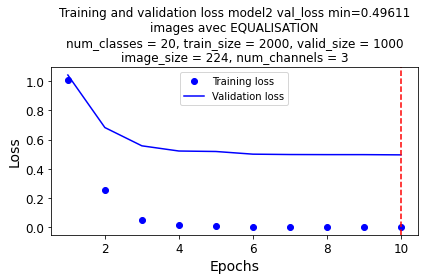

Saving figure model2 val_acc_max=0.897
images images avec EQUALISATION training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

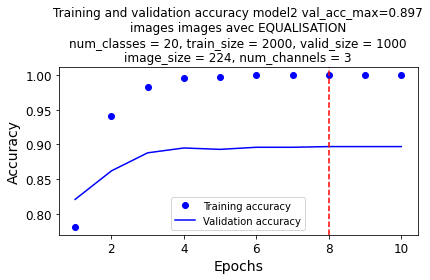

In [45]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2_info)
plot_loss(model2_info,'model2 val_loss min='+str(loss_min)+'\n'+'images avec EQUALISATION',loss_min=loss_min_epoch)
plot_accuracy(model2_info,'model2 val_acc_max='+str(acc_max)+'\n'+'images images avec EQUALISATION',acc_max=acc_max_epoch)

## Ajout de data augmentation

### Exemple

In [67]:
from keras.preprocessing.image import ImageDataGenerator

datagen_chien = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   #preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Full dataset tensor: (152, 224, 224, 3)
Photo avant et après preprocess pour le modèle VGG-16
Exemple de Data Aumentation


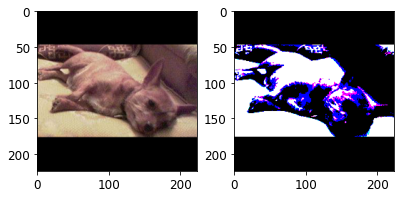

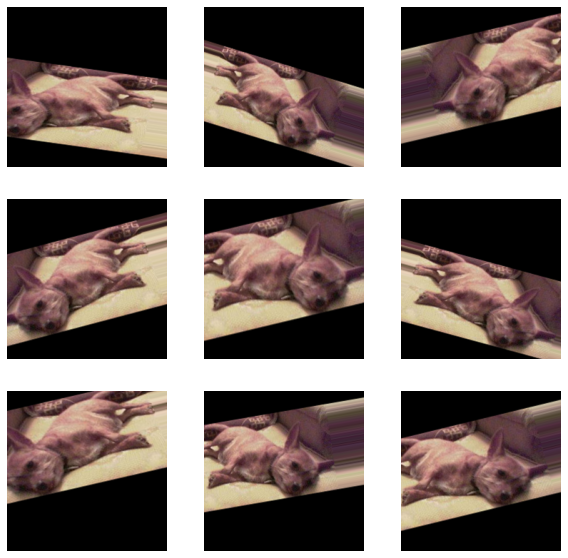

In [68]:
import tensorflow as tf

folder = 'data/Images/n02085620-Chihuahua'
dataset_chien = make_dataset_race(folder,preprocess=False)
image = dataset_chien[1,:,:,:]/255
#datagen_chien.fit(tf.expand_dims(image, 0))
print( 'Photo avant et après preprocess pour le modèle VGG-16')
plt.figure(figsize=(10, 10))
ax = plt.subplot(3, 3, 1)
plt.imshow(image)
ax = plt.subplot(3, 3, 2)
plt.imshow(preprocess_input(image*255))
plt.figure(figsize=(10, 10))
plt.axis('off')
print( 'Exemple de Data Aumentation')
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = datagen_chien.flow(tf.expand_dims(image, 0), batch_size=1)
    plt.imshow(augmented_image[0][0])
    plt.axis('off')



### Générateur

In [69]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=20,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(train_dataset) # pas nécessaire car les images sont déjà préprocessés


### Entraînement

In [70]:
# reset the weights
new_model.load_weights('model.h5')

# fits the model on batches with real-time data augmentation:
model2da_info = new_model.fit(datagen.flow(train_dataset, 
                                           train_labels_categorical, 
                                           batch_size=32),
                                initial_epoch=0,
                                validation_data=(valid_dataset, valid_labels_categorical),
                                steps_per_epoch=32,
                                epochs=15)

Epoch 1/15
32/32 [==============================] - 18s 557ms/step - loss: 1.7996 - accuracy: 0.6339 - f1_m: 0.6378 - precision_m: 0.6629 - recall_m: 0.6191 - val_loss: 0.9592 - val_accuracy: 0.8530 - val_f1_m: 0.8549 - val_precision_m: 0.8583 - val_recall_m: 0.8516
Epoch 2/15
32/32 [==============================] - 17s 538ms/step - loss: 0.9142 - accuracy: 0.8224 - f1_m: 0.8243 - precision_m: 0.8296 - recall_m: 0.8193 - val_loss: 0.9405 - val_accuracy: 0.8510 - val_f1_m: 0.8556 - val_precision_m: 0.8598 - val_recall_m: 0.8516
Epoch 3/15
32/32 [==============================] - 18s 554ms/step - loss: 0.6660 - accuracy: 0.8631 - f1_m: 0.8663 - precision_m: 0.8726 - recall_m: 0.8604 - val_loss: 0.7824 - val_accuracy: 0.8500 - val_f1_m: 0.8543 - val_precision_m: 0.8571 - val_recall_m: 0.8516
Epoch 4/15
32/32 [==============================] - 19s 592ms/step - loss: 0.5506 - accuracy: 0.8889 - f1_m: 0.8879 - precision_m: 0.8892 - recall_m: 0.8867 - val_loss: 0.8330 - val_accuracy: 0.8610 

### Résultats model 2 avec Data Aumentation

Saving figure model2 avec DA val_loss min=0.61022 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

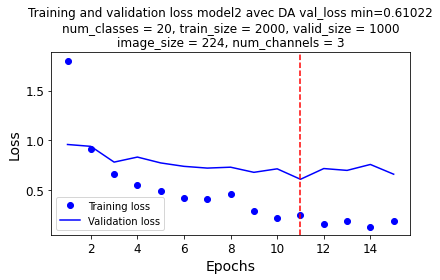

Saving figure model2 avec DA val_acc_max=0.893 training_and_validation_accuracy-num_classes=20-train_size=2000-valid_size=1000-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

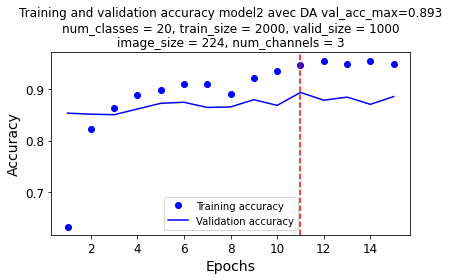

In [71]:
loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2da_info)
plot_loss(model2da_info,'model2 avec DA val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2da_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)

In [72]:

clas_report(new_model,valid_dataset,valid_labels)

Classification Report
                            precision    recall  f1-score   support

        Bedlington_terrier       0.98      0.98      0.98        50
                    collie       0.83      0.96      0.89        50
Greater_Swiss_Mountain_dog       0.91      0.84      0.87        50
              bull_mastiff       0.92      0.88      0.90        50
     flat_coated_retriever       0.84      0.94      0.89        50
                  Leonberg       0.89      0.96      0.92        50
             affenpinscher       1.00      0.88      0.94        50
          English_foxhound       0.72      0.92      0.81        50
                    kuvasz       0.83      0.88      0.85        50
             tan_coonhound       0.82      0.62      0.70        50
                bloodhound       0.87      0.68      0.76        50
           Norfolk_terrier       0.81      0.94      0.87        50
            Great_Pyrenees       0.90      0.72      0.80        50
            haired_pointe

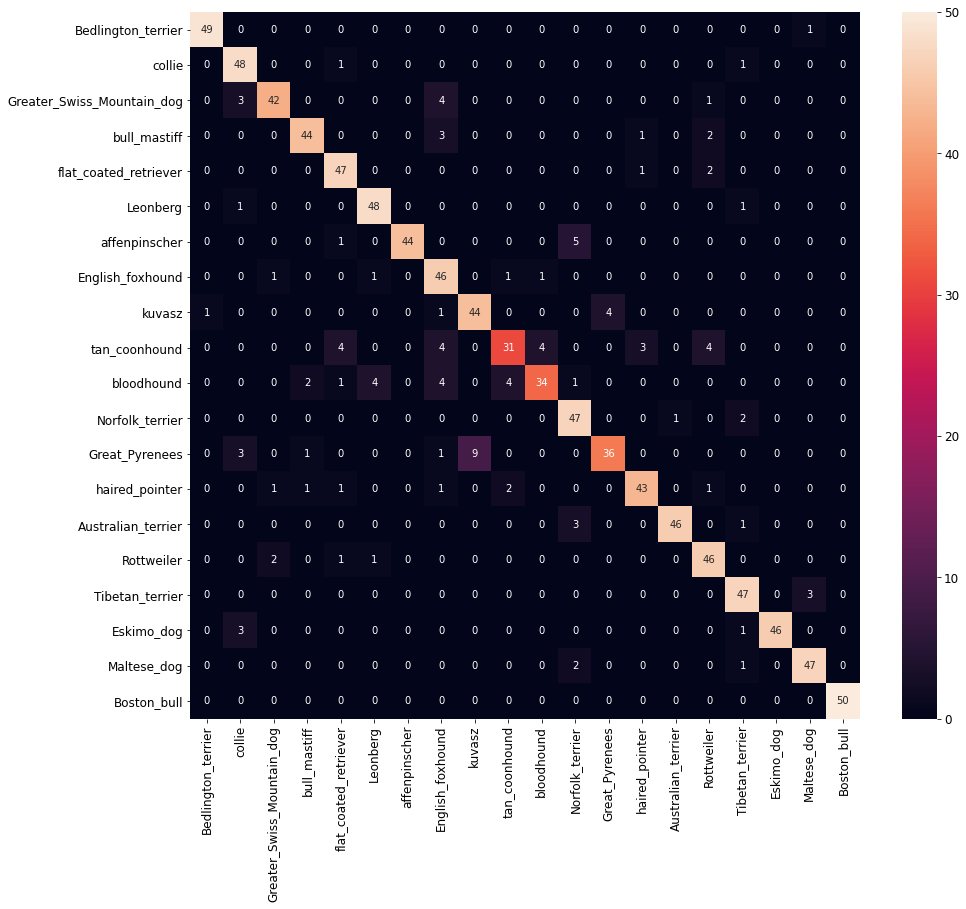

In [73]:
conf_matr(new_model,valid_dataset,valid_labels)

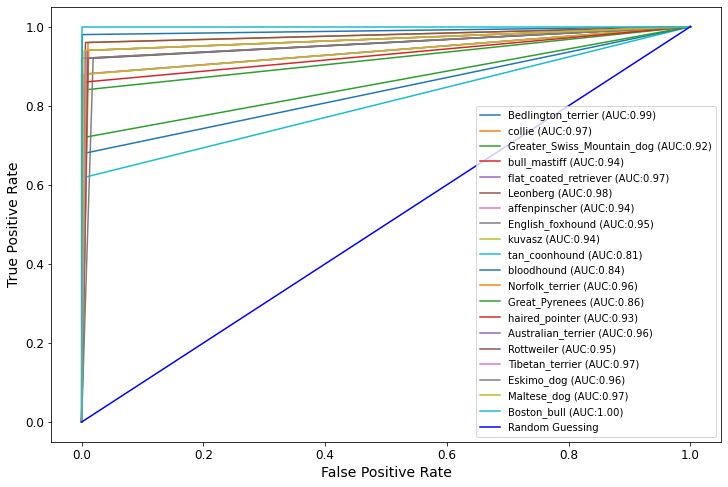

ROC AUC score: 0.9394736842105262


In [74]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         valid_dataset,
                         valid_labels,
                         dog_race_dict.keys(),
                         average="macro")
     )

# Entrainement sur toutes les classes avec DA

## Création du générateur de données

In [46]:
from keras.preprocessing.image import ImageDataGenerator

crop_images_folders_path = project_path+"data/Cropped/"
image_size = 224
num_channels = 3

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             validation_split=0.1,
                             rotation_range=20,
                             #shear_range=0.2,
                             #zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest'
                             )

train_generator = datagen.flow_from_directory(crop_images_folders_path,
                                                target_size=(image_size, image_size),
                                                batch_size=32,
                                                subset="training",
                                                class_mode='categorical')

validation_generator = datagen.flow_from_directory(crop_images_folders_path,
                                                   target_size=(image_size, image_size),
                                                   batch_size=32,
                                                   subset="validation",
                                                   class_mode='categorical')
num_classes = train_generator.num_classes
train_size = train_generator.n
valid_size = validation_generator.n

Found 18570 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.


## Modèle avec nombre de classes 120

In [47]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model,callbacks
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))

# Récupérer la sortie de ce réseau
x = model.layers[-2].output

# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes

predictions = Dense(num_classes, activation='softmax')(x)

# Stratégie #2 : extraction de features
for layer in model.layers[:-1]:
    layer.trainable = False

# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)


In [50]:
import tensorflow as tf
# Compiler le modèle
new_model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy",f1_m,precision_m,recall_m])
                  #metrics=["accuracy"])

new_model.load_weights(project_path+'models/model120_weights.h5')
new_model.save(project_path+'models/model120.h5')
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## entraînement

In [51]:
model2_120_info = new_model.fit(train_generator,
                                validation_data=validation_generator,
                                initial_epoch=0,
                                steps_per_epoch=64,
                                epochs=50)

Epoch 1/50
64/64 [==============================] - 59s 924ms/step - loss: 0.2849 - accuracy: 0.9062 - f1_m: 0.9030 - precision_m: 0.9247 - recall_m: 0.8828 - val_loss: 0.7456 - val_accuracy: 0.7889 - val_f1_m: 0.7945 - val_precision_m: 0.8230 - val_recall_m: 0.7689
Epoch 2/50
64/64 [==============================] - 56s 870ms/step - loss: 0.2801 - accuracy: 0.9067 - f1_m: 0.9039 - precision_m: 0.9246 - recall_m: 0.8848 - val_loss: 0.7218 - val_accuracy: 0.7909 - val_f1_m: 0.7993 - val_precision_m: 0.8330 - val_recall_m: 0.7688
Epoch 3/50
64/64 [==============================] - 57s 898ms/step - loss: 0.2692 - accuracy: 0.9136 - f1_m: 0.9082 - precision_m: 0.9278 - recall_m: 0.8901 - val_loss: 0.7369 - val_accuracy: 0.7899 - val_f1_m: 0.7956 - val_precision_m: 0.8268 - val_recall_m: 0.7674
Epoch 4/50
64/64 [==============================] - 59s 928ms/step - loss: 0.2900 - accuracy: 0.8993 - f1_m: 0.8971 - precision_m: 0.9208 - recall_m: 0.8753 - val_loss: 0.7272 - val_accuracy: 0.7964 

Epoch 32/50
64/64 [==============================] - 73s 1s/step - loss: 0.2235 - accuracy: 0.9219 - f1_m: 0.9232 - precision_m: 0.9366 - recall_m: 0.9106 - val_loss: 0.7698 - val_accuracy: 0.7755 - val_f1_m: 0.7785 - val_precision_m: 0.8099 - val_recall_m: 0.7504
Epoch 33/50
64/64 [==============================] - 75s 1s/step - loss: 0.2192 - accuracy: 0.9297 - f1_m: 0.9263 - precision_m: 0.9436 - recall_m: 0.9102 - val_loss: 0.7168 - val_accuracy: 0.7934 - val_f1_m: 0.7983 - val_precision_m: 0.8268 - val_recall_m: 0.7726
Epoch 34/50
64/64 [==============================] - 73s 1s/step - loss: 0.2537 - accuracy: 0.9092 - f1_m: 0.9101 - precision_m: 0.9275 - recall_m: 0.8940 - val_loss: 0.7129 - val_accuracy: 0.7954 - val_f1_m: 0.8015 - val_precision_m: 0.8328 - val_recall_m: 0.7733
Epoch 35/50
64/64 [==============================] - 75s 1s/step - loss: 0.2221 - accuracy: 0.9248 - f1_m: 0.9254 - precision_m: 0.9401 - recall_m: 0.9116 - val_loss: 0.7607 - val_accuracy: 0.7835 - val_f1

## Résultats

Saving figure model2 val_loss min=0.69558 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

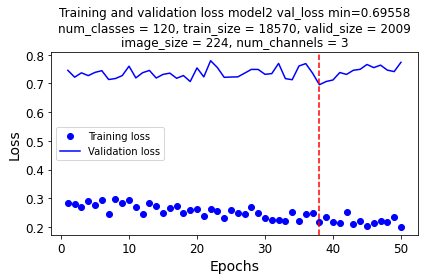

In [52]:

loss_min, loss_min_epoch, _, _ = min_loss_max_acc(model2_120_info)
plot_loss(model2_120_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)


Saving figure model2 avec DA val_acc_max=0.80139 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

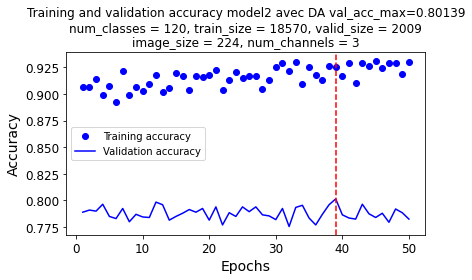

In [53]:
_, _, acc_max, acc_max_epoch = min_loss_max_acc(model2_120_info)
plot_accuracy(model2_120_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [54]:
validation_generator2 = datagen.flow_from_directory(crop_images_folders_path,
                                                   target_size=(image_size, image_size),
                                                   batch_size=1500,
                                                   subset="validation",
                                                   class_mode='categorical')

(images,labels) = next(validation_generator2)

Found 2009 images belonging to 120 classes.


In [55]:
labels2=np.zeros(labels.shape[0])
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j]==1:
            labels2[i]=j
            
# tester Argmax 

In [56]:

clas_report(new_model,images,labels2,validation_generator.class_indices)

Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       1.00      1.00      1.00        13
              n02085782-Japanese_spaniel       0.86      1.00      0.92        12
                   n02085936-Maltese_dog       0.84      0.89      0.86        18
                      n02086079-Pekinese       0.64      0.78      0.70         9
                      n02086240-Shih_Tzu       0.59      0.59      0.59        17
              n02086646-Blenheim_spaniel       1.00      0.93      0.96        14
                      n02086910-papillon       0.93      1.00      0.97        14
                   n02087046-toy_terrier       0.77      0.77      0.77        13
           n02087394-Rhodesian_ridgeback       1.00      0.43      0.60        14
                  n02088094-Afghan_hound       0.93      0.93      0.93        15
                        n02088238-basset       0.83      0.83      0.83    

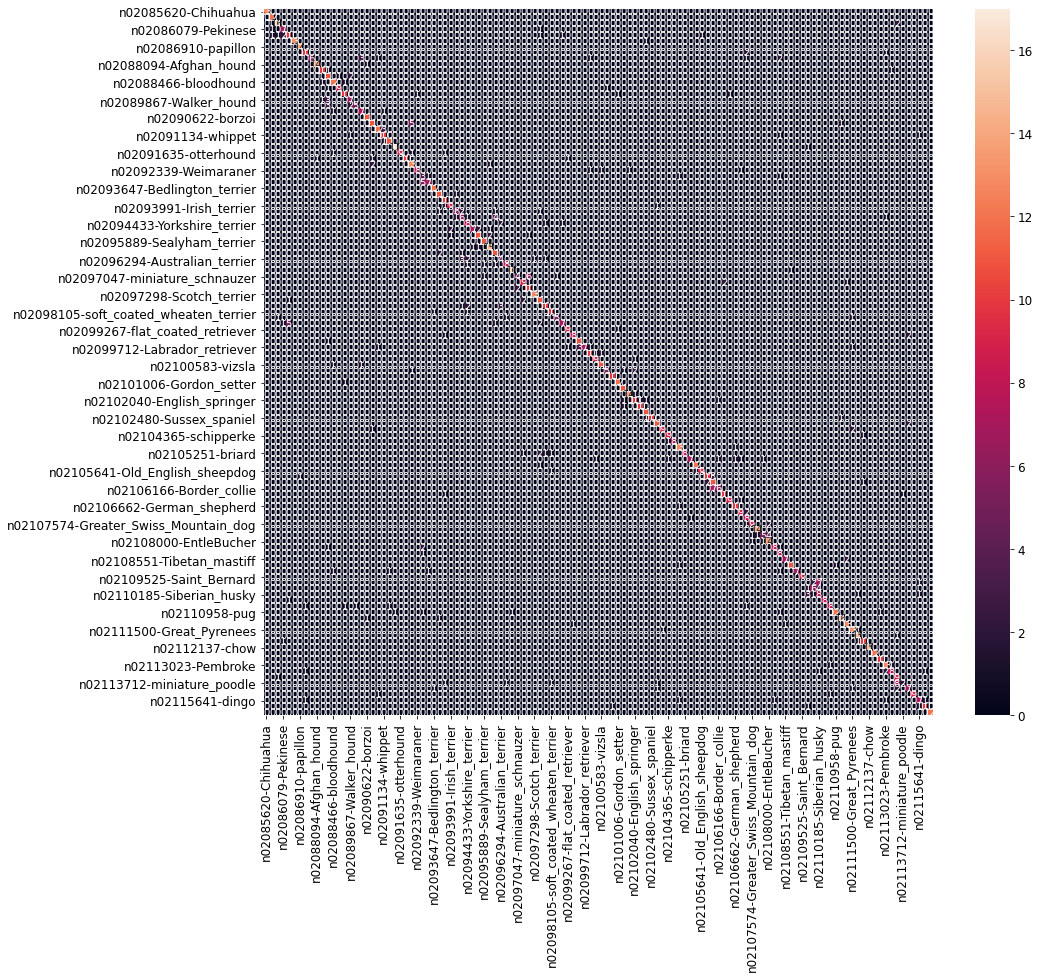

In [57]:
conf_matr(new_model,images,labels2,validation_generator.class_indices)

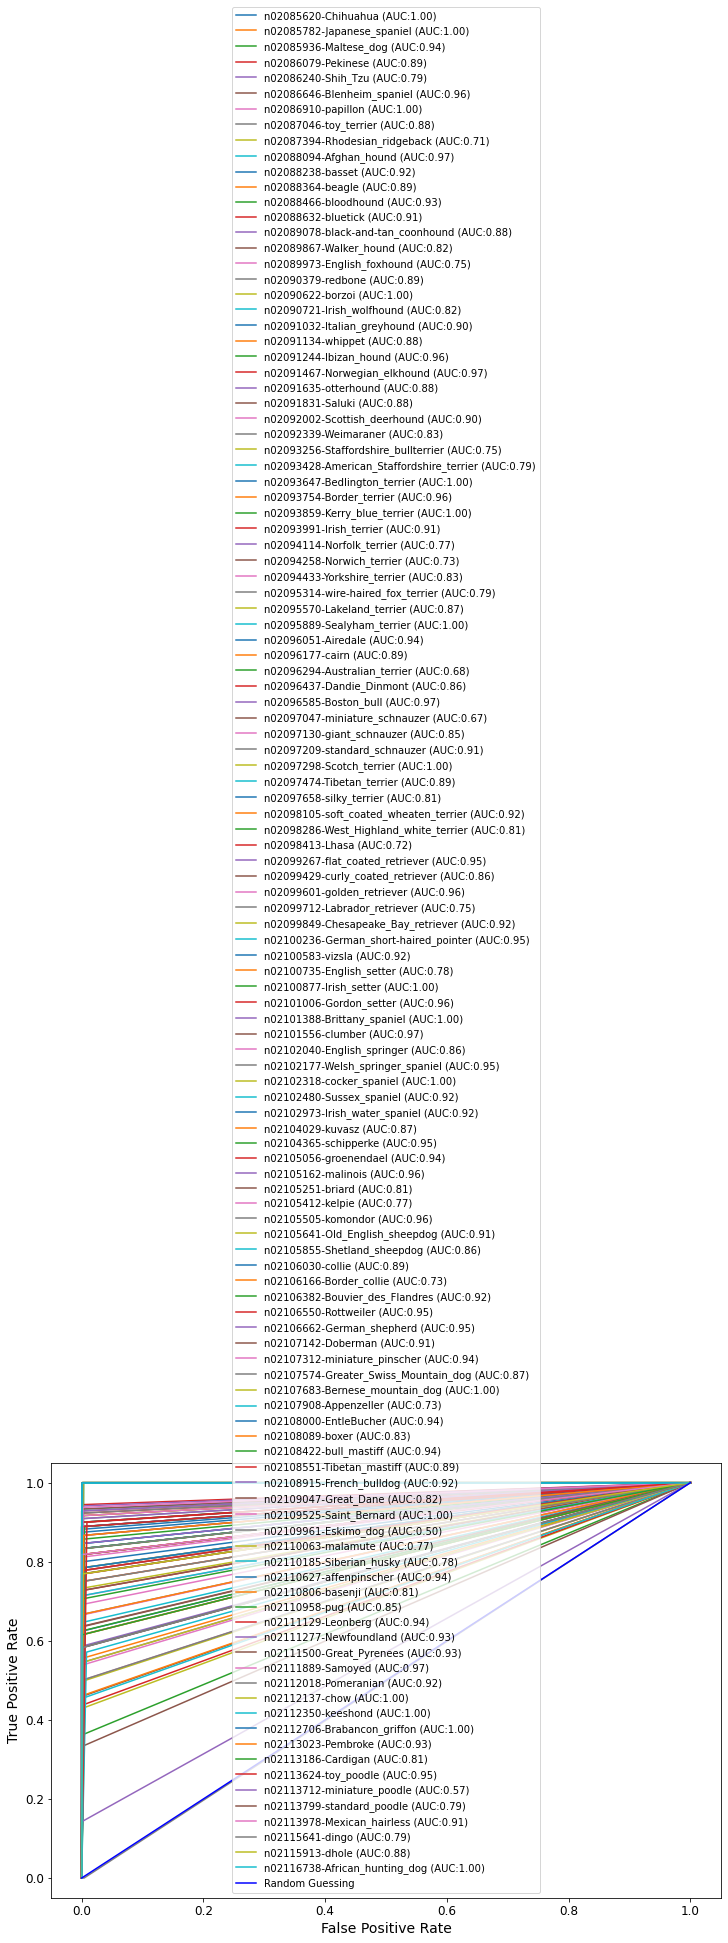

ROC AUC score: 0.8863448819247212


In [58]:
print('ROC AUC score:',
multiclass_roc_auc_score(new_model,
                         images,
                         labels2,
                         validation_generator.class_indices.keys(),
                         validation_generator.class_indices,
                         average="macro")
     )

## Fine tunning

In [59]:
for layer in new_model.layers[-2:-1]:
    layer.trainable = True
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [60]:
new_model.load_weights(project_path+'models/model120_weights.h5')

In [61]:
model2ft_120_info = new_model.fit(train_generator,
                                validation_data=validation_generator,
                                initial_epoch=50,
                                steps_per_epoch=64,
                                epochs=100)

Epoch 51/100
64/64 [==============================] - 37s 576ms/step - loss: 0.2667 - accuracy: 0.9146 - f1_m: 0.9156 - precision_m: 0.9368 - recall_m: 0.8960 - val_loss: 0.7217 - val_accuracy: 0.7880 - val_f1_m: 0.7925 - val_precision_m: 0.8228 - val_recall_m: 0.7652
Epoch 52/100
64/64 [==============================] - 61s 960ms/step - loss: 0.2748 - accuracy: 0.9141 - f1_m: 0.9135 - precision_m: 0.9327 - recall_m: 0.8955 - val_loss: 0.6952 - val_accuracy: 0.7835 - val_f1_m: 0.7864 - val_precision_m: 0.8228 - val_recall_m: 0.7539
Epoch 53/100
64/64 [==============================] - 67s 1s/step - loss: 0.2949 - accuracy: 0.9062 - f1_m: 0.9005 - precision_m: 0.9239 - recall_m: 0.8789 - val_loss: 0.7266 - val_accuracy: 0.7894 - val_f1_m: 0.7946 - val_precision_m: 0.8289 - val_recall_m: 0.7639
Epoch 54/100
64/64 [==============================] - 65s 1s/step - loss: 0.2742 - accuracy: 0.9062 - f1_m: 0.9051 - precision_m: 0.9294 - recall_m: 0.8828 - val_loss: 0.7342 - val_accuracy: 0.791

64/64 [==============================] - 66s 1s/step - loss: 0.2616 - accuracy: 0.9185 - f1_m: 0.9184 - precision_m: 0.9355 - recall_m: 0.9023 - val_loss: 0.7141 - val_accuracy: 0.7949 - val_f1_m: 0.7966 - val_precision_m: 0.8267 - val_recall_m: 0.7694
Epoch 82/100
64/64 [==============================] - 63s 991ms/step - loss: 0.2470 - accuracy: 0.9126 - f1_m: 0.9096 - precision_m: 0.9268 - recall_m: 0.8936 - val_loss: 0.7388 - val_accuracy: 0.7885 - val_f1_m: 0.7950 - val_precision_m: 0.8282 - val_recall_m: 0.7655
Epoch 83/100
64/64 [==============================] - 66s 1s/step - loss: 0.2246 - accuracy: 0.9199 - f1_m: 0.9176 - precision_m: 0.9406 - recall_m: 0.8965 - val_loss: 0.7547 - val_accuracy: 0.7825 - val_f1_m: 0.7906 - val_precision_m: 0.8207 - val_recall_m: 0.7636
Epoch 84/100
64/64 [==============================] - 57s 900ms/step - loss: 0.2340 - accuracy: 0.9175 - f1_m: 0.9157 - precision_m: 0.9339 - recall_m: 0.8989 - val_loss: 0.7548 - val_accuracy: 0.7924 - val_f1_m:

In [62]:
#new_model.save_weights(project_path+'models/model120_weights.h5')

In [ ]:
#new_model.save(project_path+'models/model120.h5')

## Résultats

Saving figure model2 val_loss min=0.68835 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

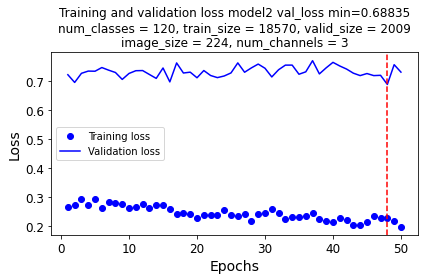

Saving figure model2 avec DA val_acc_max=0.7999 training_and_validation_accuracy-num_classes=120-train_size=18570-valid_size=2009-image_size=224-num_channels=3


<Figure size 432x288 with 0 Axes>

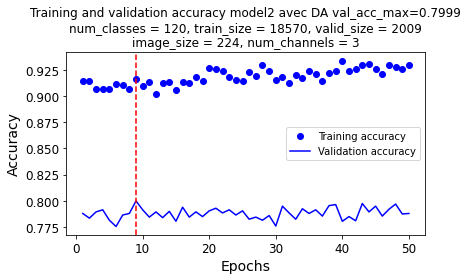

In [63]:

loss_min, loss_min_epoch, acc_max, acc_max_epoch = min_loss_max_acc(model2ft_120_info)

plot_loss(model2ft_120_info,'model2 val_loss min='+str(loss_min),loss_min=loss_min_epoch)
plot_accuracy(model2ft_120_info,'model2 avec DA val_acc_max='+str(acc_max),acc_max=acc_max_epoch)


In [64]:
acc = [0.] + model2_120_info.history['accuracy']
val_acc = [0.] + model2_120_info.history['val_accuracy']

loss = model2_120_info.history['loss']
val_loss = model2_120_info.history['val_loss']


acc += model2ft_120_info.history['accuracy']
val_acc += model2ft_120_info.history['val_accuracy']

loss += model2ft_120_info.history['loss']
val_loss += model2ft_120_info.history['val_loss']

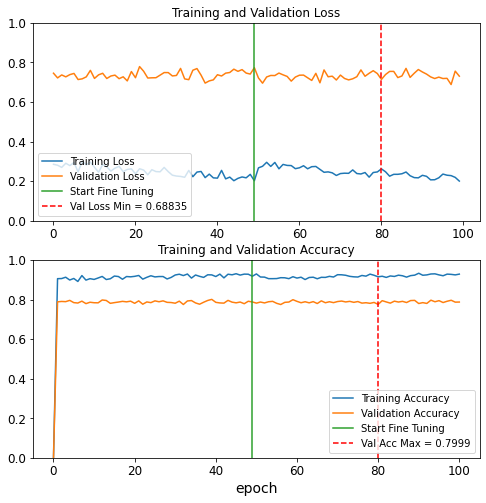

In [65]:
initial_epochs = 50
loss_min_epoch = initial_epochs + 30
acc_max_epoch = initial_epochs + 30

plt.figure(figsize=(8, 8)).patch.set_facecolor('w')
plt.axvline(x=loss_min,color='red',linestyle='--')
plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.axvline(x=acc_max_epoch,color='red',linestyle='--',label="Val Acc Max = "+str(acc_max))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.axvline(x=loss_min_epoch,color='red',linestyle='--',label="Val Loss Min = "+str(loss_min))
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')


plt.show()

In [66]:
def top_mismach(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    array = confusion_matrix(valid_labels, valid_labels_pred)
    df_cm = pd.DataFrame(array, index = [i for i in dog_race_dict.keys()],
                              columns = [i for i in dog_race_dict.keys()])
    #plt.figure(figsize = (15,13)).patch.set_facecolor('w')
    #sn.heatmap(df_cm, annot=True)
    dict = {}
    for i in df_cm.columns:
        for j in df_cm.index:
            if i!=j:
                dict[i + " / " + j] = df_cm[i][df_cm.index==j].values[0]
    sort_orders = sorted(dict.items(), key=lambda x: x[1], reverse=True)
    return sort_orders

In [67]:
races_dict = validation_generator.class_indices
races_invert_dict = {v: k.split("-")[-1] for k, v in races_dict.items()}
races_dict = {v: k for k, v in races_invert_dict.items()}

In [68]:
sort_orders = top_mismach(new_model,images,labels2,races_dict)

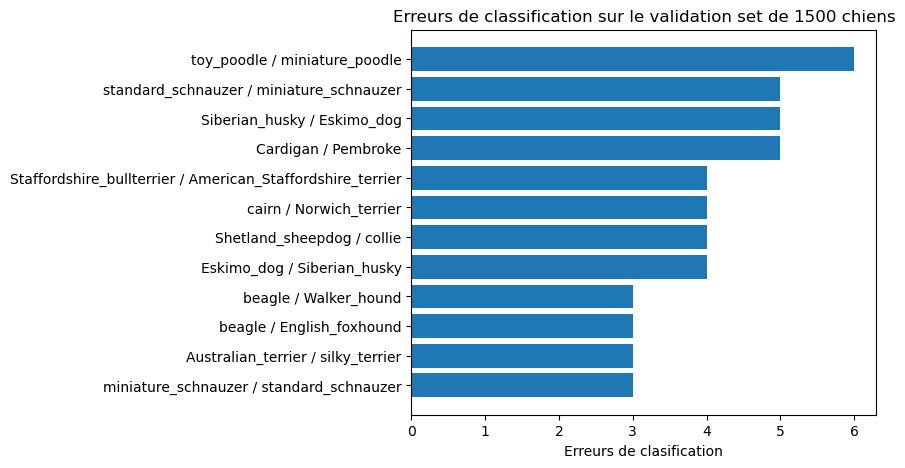

In [75]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots(figsize = (6, 5))

couples = np.array(sort_orders[:12])[:,0]
erreurs = np.array(sort_orders[:12])[:,1].astype(int)
y_pos = np.arange(len(couples))
#for i in sort_orders:
	#print(i[0], i[1])


ax.barh(couples, erreurs , align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(couples)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Erreurs de clasification')
ax.set_title('Erreurs de classification sur le validation set de 1500 chiens')

plt.show()

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
def clas_report(model,valid_dataset,valid_labels,dog_race_dict=dog_race_dict):
    # Classification Report
    Y_pred = model.predict(valid_dataset)
    valid_labels_pred = np.argmax(Y_pred, axis=1)
    class_report = classification_report(valid_labels, valid_labels_pred, target_names=dog_race_dict.keys())
    print('Classification Report')
    print(class_report)
    return clas_report

In [77]:

report = clas_report(new_model,images,labels2,races_dict)

Classification Report
                                precision    recall  f1-score   support

                     Chihuahua       1.00      1.00      1.00        13
              Japanese_spaniel       0.86      1.00      0.92        12
                   Maltese_dog       0.84      0.89      0.86        18
                      Pekinese       0.78      0.78      0.78         9
                      Shih_Tzu       0.71      0.59      0.65        17
              Blenheim_spaniel       0.93      0.93      0.93        14
                      papillon       0.93      1.00      0.97        14
                   toy_terrier       0.75      0.92      0.83        13
           Rhodesian_ridgeback       0.75      0.64      0.69        14
                  Afghan_hound       1.00      0.93      0.97        15
                        basset       0.85      0.92      0.88        12
                        beagle       0.55      0.79      0.65        14
                    bloodhound       0.75